<hr/>

<hr/>

In [3]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install toad

     |████████████████████████████████| 14.8 MB 2.1 MB/s            
     |████████████████████████████████| 292 kB 62.9 MB/s            
     |████████████████████████████████| 2.0 MB 48.5 MB/s            
     |████████████████████████████████| 14.8 MB 42.0 MB/s            
     |████████████████████████████████| 14.8 MB 40.0 MB/s            
     |████████████████████████████████| 14.8 MB 51.5 MB/s            
     |████████████████████████████████| 14.8 MB 44.4 MB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.16.4
    Uninstalling numpy-1.16.4:
      Successfully uninstalled numpy-1.16.4
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.9.0
    Uninstalling seaborn-0.9.0:
      Successfully uninstalled seaborn-0.9.0
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.12
    Uninstalling Cython-0.29.12:
      Successfully uninstalled Cython-0.29.12
ERROR: pip's dependency resolver does not curren

## <span id="1"></span> ** 1. Overview **

## <span id="2"></span> ** 2. Importing Libraries and Reading the Dataset **

In [272]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from collections import Counter
from IPython.core.display import display, HTML
from sklearn import datasets
from matplotlib import pyplot as plt
import toad
import jieba
from sklearn.model_selection import train_test_split
sns.set_style('darkgrid')

In [290]:
import time
from sklearn.datasets import load_boston
dataset = pd.read_excel("/input/fxmonth/USD_CNY_Month.xlsx")
dataset.columns

Index(['Underlying', 'Type', 'Strike', 'Expiry', 'Notional', 'Curr', 'Premium',
       'Curr.1', 'Style', 'Code', 'Clr', 'Trd Time'],
      dtype='object')

In [292]:
d_min = pd.read_excel("/input/minute/USD_CNY_ Minute.xlsx")
d_min.head()

Date      ER
0  2022-11-24T04:30:00.000Z  7.1365
1  2022-11-24T04:29:00.000Z  7.1365
2  2022-11-24T04:12:00.000Z  7.1365
3  2022-11-24T04:11:00.000Z  7.1359
4  2022-11-24T04:09:00.000Z  7.1351

**Converts the string time to a unix timestamp**

In [293]:
def Changetime(str1):
    try:
        str1 = str(str1)
        Unixtime = int(time.mktime(time.strptime(str1, '%m/%d/%Y %H:%M:%S'))*1000)
    except:
        print("**"+str1)
    return Unixtime


In [294]:
def Changetime1(str1):
    try:
        str1 = str(str1)
        Unixtime = int(time.mktime(time.strptime(str1, '%Y-%m-%dT%H:%M:%S.000Z'))*1000)
    except:
        print("**"+str1)
    return Unixtime

Changetime1('2022-11-24T00:00:00.000Z')

1669248000000

per ms
1 1ms
1s 1000
1hour 3600000
1day 86400000
1week 604800000
1month 2629743000

In [295]:
dataset["Trd Time"] = dataset["Trd Time"].apply(Changetime)


In [296]:
d_min["ER"]

0        7.1365
1        7.1365
2        7.1365
3        7.1359
4        7.1351
5        7.1351
6        7.1350
7        7.1340
8        7.1340
9        7.1337
10       7.1337
11       7.1336
12       7.1350
13       7.1350
14       7.1350
15       7.1354
16       7.1371
17       7.1383
18       7.1386
19       7.1386
20       7.1386
21       7.1390
22       7.1391
23       7.1396
24       7.1396
25       7.1395
26       7.1396
27       7.1397
28       7.1397
29       7.1400
          ...  
13806    7.1902
13807    7.1903
13808    7.1901
13809    7.1889
13810    7.1901
13811    7.1900
13812    7.1896
13813    7.1902
13814    7.1892
13815    7.1892
13816    7.1895
13817    7.1911
13818    7.1900
13819    7.1893
13820    7.1891
13821    7.1867
13822    7.1867
13823    7.1865
13824    7.1838
13825    7.1838
13826    7.1822
13827    7.1805
13828    7.1785
13829    7.1788
13830    7.1794
13831    7.1798
13832    7.1792
13833    7.1792
13834    7.1801
13835    7.1801
Name: ER, Length: 13836,

In [297]:
d_min["Date"] = d_min["Date"].apply(Changetime1)

In [298]:
dataset.head()

Underlying Type  Strike    Expiry   Notional Curr   Premium  \
0  USD CNY Vanilla Option    C    7.35  02/02/23  100000000  USD  537100.0   
1  USD CNY Vanilla Option    C    7.45  02/02/23  100000000  USD  352100.0   
2  USD CNY Vanilla Option    C    7.17  12/02/22   20000000  USD   94800.0   
3  USD CNY Vanilla Option    C    7.30  12/02/22   30000000  USD   29700.0   
4  USD CNY Vanilla Option    C    7.10  01/11/23   40000000  USD  541000.0   

  Curr.1 Style Code Clr       Trd Time  
0    USD    EU   TR   U  1668784397000  
1    USD    EU   TR   U  1668784397000  
2    USD    EU   TR   U  1668776695000  
3    USD    EU   TR   U  1668776695000  
4    USD    EU   TR   U  1668776551000

## <span id="2"></span> ** 2. data encoding **

In [299]:
dataset["Trd Time"].isnull().sum()
print(len(dataset["Trd Time"]))
print(dataset["Trd Time"][len(dataset["Trd Time"])-1])

3276
1666126615000


**find er after 1min / 30 min / 1 hour /1 day**

In [300]:
def find1min_er(a):
    for i,j in zip(d_min['Date'], d_min['ER']):
        if((a-i)>10000 and (a-i)<10*60000):
            return j
    return -1
dataset["1min"] = dataset["Trd Time"].apply(find1min_er)
dataset["1min"].value_counts()

-1.0000    1328
 7.3000      21
 7.3040      18
 7.3089      17
 7.2860      17
 7.2797      16
 7.3036      15
 7.2986      14
 7.2623      14
 7.3083      13
 7.3163      13
 7.2256      13
 7.2270      13
 7.2215      12
 7.2362      12
 7.1716      12
 7.3138      12
 7.2500      12
 7.2970      11
 7.2470      10
 7.3060      10
 7.3022      10
 7.3071      10
 7.3020      10
 7.2452       9
 7.2977       9
 7.0773       9
 7.1208       9
 7.3081       9
 7.2528       9
           ... 
 7.2796       1
 7.2457       1
 7.3148       1
 7.1260       1
 7.2591       1
 7.1809       1
 7.2336       1
 7.2766       1
 7.2402       1
 7.2961       1
 7.3114       1
 7.1690       1
 7.0372       1
 7.3239       1
 7.3038       1
 7.0589       1
 7.0453       1
 7.0797       1
 7.0660       1
 7.3110       1
 7.2924       1
 7.0967       1
 7.2158       1
 7.0590       1
 7.2703       1
 7.3029       1
 7.2085       1
 7.0516       1
 7.3234       1
 7.2407       1
Name: 1min, Length: 717,

In [301]:
def find30min_er(a):
    for i,j in zip(d_min['Date'], d_min['ER']):
        if((a-i)>10*60000 and (a-i)<50*60000):
            return j
    return -1
dataset["30min"] = dataset["Trd Time"].apply(find1min_er)
dataset["30min"].value_counts()

-1.0000    1328
 7.3000      21
 7.3040      18
 7.3089      17
 7.2860      17
 7.2797      16
 7.3036      15
 7.2986      14
 7.2623      14
 7.3083      13
 7.3163      13
 7.2256      13
 7.2270      13
 7.2215      12
 7.2362      12
 7.1716      12
 7.3138      12
 7.2500      12
 7.2970      11
 7.2470      10
 7.3060      10
 7.3022      10
 7.3071      10
 7.3020      10
 7.2452       9
 7.2977       9
 7.0773       9
 7.1208       9
 7.3081       9
 7.2528       9
           ... 
 7.2796       1
 7.2457       1
 7.3148       1
 7.1260       1
 7.2591       1
 7.1809       1
 7.2336       1
 7.2766       1
 7.2402       1
 7.2961       1
 7.3114       1
 7.1690       1
 7.0372       1
 7.3239       1
 7.3038       1
 7.0589       1
 7.0453       1
 7.0797       1
 7.0660       1
 7.3110       1
 7.2924       1
 7.0967       1
 7.2158       1
 7.0590       1
 7.2703       1
 7.3029       1
 7.2085       1
 7.0516       1
 7.3234       1
 7.2407       1
Name: 30min, Length: 717

In [302]:
def find1h_er(a):
    for i,j in zip(d_min['Date'], d_min['ER']):
        if((a-i)>60*60000 and (a-i)<120*60000):
            return j
    return -1
dataset["1h"] = dataset["Trd Time"].apply(find1min_er)
dataset["1h"].value_counts()

-1.0000    1328
 7.3000      21
 7.3040      18
 7.3089      17
 7.2860      17
 7.2797      16
 7.3036      15
 7.2986      14
 7.2623      14
 7.3083      13
 7.3163      13
 7.2256      13
 7.2270      13
 7.2215      12
 7.2362      12
 7.1716      12
 7.3138      12
 7.2500      12
 7.2970      11
 7.2470      10
 7.3060      10
 7.3022      10
 7.3071      10
 7.3020      10
 7.2452       9
 7.2977       9
 7.0773       9
 7.1208       9
 7.3081       9
 7.2528       9
           ... 
 7.2796       1
 7.2457       1
 7.3148       1
 7.1260       1
 7.2591       1
 7.1809       1
 7.2336       1
 7.2766       1
 7.2402       1
 7.2961       1
 7.3114       1
 7.1690       1
 7.0372       1
 7.3239       1
 7.3038       1
 7.0589       1
 7.0453       1
 7.0797       1
 7.0660       1
 7.3110       1
 7.2924       1
 7.0967       1
 7.2158       1
 7.0590       1
 7.2703       1
 7.3029       1
 7.2085       1
 7.0516       1
 7.3234       1
 7.2407       1
Name: 1h, Length: 717, d

In [303]:
def find1d_er(a):
    for i,j in zip(d_min['Date'], d_min['EUR=']):
        if((a-i)>24*60*60000 and (a-i)<48*60*60000):
            return j
    return -1
dataset["1d"] = dataset["Trd Time"].apply(find1min_er)
dataset["1d"].value_counts()

-1.0000    1328
 7.3000      21
 7.3040      18
 7.3089      17
 7.2860      17
 7.2797      16
 7.3036      15
 7.2986      14
 7.2623      14
 7.3083      13
 7.3163      13
 7.2256      13
 7.2270      13
 7.2215      12
 7.2362      12
 7.1716      12
 7.3138      12
 7.2500      12
 7.2970      11
 7.2470      10
 7.3060      10
 7.3022      10
 7.3071      10
 7.3020      10
 7.2452       9
 7.2977       9
 7.0773       9
 7.1208       9
 7.3081       9
 7.2528       9
           ... 
 7.2796       1
 7.2457       1
 7.3148       1
 7.1260       1
 7.2591       1
 7.1809       1
 7.2336       1
 7.2766       1
 7.2402       1
 7.2961       1
 7.3114       1
 7.1690       1
 7.0372       1
 7.3239       1
 7.3038       1
 7.0589       1
 7.0453       1
 7.0797       1
 7.0660       1
 7.3110       1
 7.2924       1
 7.0967       1
 7.2158       1
 7.0590       1
 7.2703       1
 7.3029       1
 7.2085       1
 7.0516       1
 7.3234       1
 7.2407       1
Name: 1d, Length: 717, d

In [304]:
dataset.head()

Underlying Type  Strike    Expiry   Notional Curr   Premium  \
0  USD CNY Vanilla Option    C    7.35  02/02/23  100000000  USD  537100.0   
1  USD CNY Vanilla Option    C    7.45  02/02/23  100000000  USD  352100.0   
2  USD CNY Vanilla Option    C    7.17  12/02/22   20000000  USD   94800.0   
3  USD CNY Vanilla Option    C    7.30  12/02/22   30000000  USD   29700.0   
4  USD CNY Vanilla Option    C    7.10  01/11/23   40000000  USD  541000.0   

  Curr.1 Style Code Clr       Trd Time   1min  30min     1h     1d  
0    USD    EU   TR   U  1668784397000 -1.000 -1.000 -1.000 -1.000  
1    USD    EU   TR   U  1668784397000 -1.000 -1.000 -1.000 -1.000  
2    USD    EU   TR   U  1668776695000  7.115  7.115  7.115  7.115  
3    USD    EU   TR   U  1668776695000  7.115  7.115  7.115  7.115  
4    USD    EU   TR   U  1668776551000  7.115  7.115  7.115  7.115

In [305]:
def hotEncoding(NAME):
    value = dataset[NAME].value_counts()
    value_map = dict((v, i) for i,v in enumerate(value.index))
    dataset[NAME] = dataset.replace({NAME:value_map})[NAME]
hotEncoding('Underlying') 

In [306]:
def typecoding(NAME): 
    value1 = dataset[NAME].astype('category')
    dataset[NAME] = value1.cat.codes
typecoding('Curr')
typecoding('Type')
typecoding('Curr.1')
typecoding('Style')
typecoding('Code')
typecoding('Clr')
dataset['Underlying'] = dataset['Underlying'] +1
dataset['Type'] = dataset['Type'] +1
dataset['Curr'] = dataset['Curr'] +1
dataset['Curr.1'] = dataset['Curr.1'] +1
dataset.head()

Underlying  Type  Strike    Expiry   Notional  Curr   Premium  Curr.1  \
0           1     1    7.35  02/02/23  100000000     1  537100.0       2   
1           1     1    7.45  02/02/23  100000000     1  352100.0       2   
2           1     1    7.17  12/02/22   20000000     1   94800.0       2   
3           1     1    7.30  12/02/22   30000000     1   29700.0       2   
4           1     1    7.10  01/11/23   40000000     1  541000.0       2   

   Style  Code  Clr       Trd Time   1min  30min     1h     1d  
0      0     2    0  1668784397000 -1.000 -1.000 -1.000 -1.000  
1      0     2    0  1668784397000 -1.000 -1.000 -1.000 -1.000  
2      0     2    0  1668776695000  7.115  7.115  7.115  7.115  
3      0     2    0  1668776695000  7.115  7.115  7.115  7.115  
4      0     2    0  1668776551000  7.115  7.115  7.115  7.115

In [307]:
dataset = dataset.drop(['Expiry','Clr'], axis=1)
# dataset['toprice'] = dataset['Notional']/2+dataset['Premium']
# dataset['delrate'] = dataset['Premium']/(dataset['Curr']+1)
from sklearn import svm
from sklearn import datasets
from sklearn.model_selection import train_test_split as ts
dataset.head()

Underlying  Type  Strike   Notional  Curr   Premium  Curr.1  Style  Code  \
0           1     1    7.35  100000000     1  537100.0       2      0     2   
1           1     1    7.45  100000000     1  352100.0       2      0     2   
2           1     1    7.17   20000000     1   94800.0       2      0     2   
3           1     1    7.30   30000000     1   29700.0       2      0     2   
4           1     1    7.10   40000000     1  541000.0       2      0     2   

        Trd Time   1min  30min     1h     1d  
0  1668784397000 -1.000 -1.000 -1.000 -1.000  
1  1668784397000 -1.000 -1.000 -1.000 -1.000  
2  1668776695000  7.115  7.115  7.115  7.115  
3  1668776695000  7.115  7.115  7.115  7.115  
4  1668776551000  7.115  7.115  7.115  7.115

## <span id="3"></span> ** 3. Data Analysis **

### <span id="4"></span> ** Data Preprocessing **

Are there missing values? There isn't any missing values as shown below.

In [308]:
dataset= dataset.dropna()


### <span id="5"></span> ** using toad to perform exploratory data analysis and visualization**

In [309]:
dataset.isnull().sum()

Underlying    0
Type          0
Strike        0
Notional      0
Curr          0
Premium       0
Curr.1        0
Style         0
Code          0
Trd Time      0
1min          0
30min         0
1h            0
1d            0
dtype: int64

In [310]:
tance = toad.detector.detect(dataset)

In [311]:
tance

type  size missing  unique  mean_or_top1   std_or_top2  \
Underlying    int64  3276   0.00%       1  1.000000e+00  0.000000e+00   
Type           int8  3276   0.00%       1  1.000000e+00  0.000000e+00   
Strike      float64  3276   0.00%     553  7.921274e+00  2.047757e+01   
Notional      int64  3276   0.00%     127  5.370190e+07  7.150841e+07   
Curr           int8  3276   0.00%       1  1.000000e+00  0.000000e+00   
Premium     float64  3276   0.00%    2703  4.735079e+05  8.975539e+05   
Curr.1         int8  3276   0.00%       2  1.975580e+00  1.543728e-01   
Style          int8  3276   0.00%       1  0.000000e+00  0.000000e+00   
Code           int8  3276   0.00%       3  1.971306e+00  2.273665e-01   
Trd Time      int64  3276   0.00%    2528  1.667432e+12  7.713456e+08   
1min        float64  3276   0.00%     717  3.891880e+00  4.040112e+00   
30min       float64  3276   0.00%     717  3.891880e+00  4.040112e+00   
1h          float64  3276   0.00%     717  3.891880e+00  4.040112e+00   
1d          float64  3276   0.00%     717  3.891880e+00  4.040112e+00   

             min_or_top3    1%_or_top4   10%_or_top5  50%_or_bottom5  \
Underlying  1.000000e+00  1.000000e+00  1.000000e+00    1.000000e+00   
Type        1.000000e+00  1.000000e+00  1.000000e+00    1.000000e+00   
Strike      1.364536e-01  6.677925e+00  7.089250e+00    7.300000e+00   
Notional    1.000000e+03  1.000000e+05  5.000000e+05    2.500000e+07   
Curr        1.000000e+00  1.000000e+00  1.000000e+00    1.000000e+00   
Premium     0.000000e+00  1.432500e+00  2.850000e+03    1.523850e+05   
Curr.1      1.000000e+00  1.000000e+00  2.000000e+00    2.000000e+00   
Style       0.000000e+00  0.000000e+00  0.000000e+00    0.000000e+00   
Code        0.000000e+00  0.000000e+00  2.000000e+00    2.000000e+00   
Trd Time    1.666127e+12  1.666143e+12  1.666321e+12    1.667443e+12   
1min       -1.000000e+00 -1.000000e+00 -1.000000e+00    7.131300e+00   
30min      -1.000000e+00 -1.000000e+00 -1.000000e+00    7.131300e+00   
1h         -1.000000e+00 -1.000000e+00 -1.000000e+00    7.131300e+00   
1d         -1.000000e+00 -1.000000e+00 -1.000000e+00    7.131300e+00   

            75%_or_bottom4  90%_or_bottom3  99%_or_bottom2  max_or_bottom1  
Underlying    1.000000e+00    1.000000e+00    1.000000e+00    1.000000e+00  
Type          1.000000e+00    1.000000e+00    1.000000e+00    1.000000e+00  
Strike        7.400000e+00    7.500000e+00    8.000000e+00    6.913000e+02  
Notional      7.500000e+07    1.850000e+08    2.500000e+08    2.500000e+08  
Curr          1.000000e+00    1.000000e+00    1.000000e+00    1.000000e+00  
Premium       5.174000e+05    1.230108e+06    4.033400e+06    1.182775e+07  
Curr.1        2.000000e+00    2.000000e+00    2.000000e+00    2.000000e+00  
Style         0.000000e+00    0.000000e+00    0.000000e+00    0.000000e+00  
Code          2.000000e+00    2.000000e+00    2.000000e+00    2.000000e+00  
Trd Time      1.668074e+12    1.668515e+12    1.668739e+12    1.668784e+12  
1min          7.253200e+00    7.300100e+00    7.313900e+00    7.325900e+00  
30min         7.253200e+00    7.300100e+00    7.313900e+00    7.325900e+00  
1h            7.253200e+00    7.300100e+00    7.313900e+00    7.325900e+00  
1d            7.253200e+00    7.300100e+00    7.313900e+00    7.325900e+00

## <span id="3"></span> 1. 1min model 

In [312]:
X = dataset[['Notional','Premium']].iloc[:,:]

y = dataset.iloc[:,10]
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (2293, 2)
Shape of X_test:  (983, 2)
Shape of y_train:  (2293,)
Shape of y_test (983,)


In [313]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
from sklearn.metrics import r2_score
from sklearn import ensemble
# Predicting Cross Validation Score the Test set results
cv = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_train = regressor.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)

# Predicting R2 Score the Test set results
y_pred_test = regressor.predict(X_test)
r2_score_test = r2_score(y_test, y_pred_test)

# Predicting RMSE the Test set results
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("CV: ", cv.mean())
print('R2_score (train): ', r2_score_train)
print('R2_score (test): ', r2_score_test)
print("RMSE: ", rmse)

CV:  -0.0013905403249895643
R2_score (train):  0.004942774599283273
R2_score (test):  0.010384450473209128
RMSE:  4.037024001958802


In [314]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X_train)
y_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))
# Fitting the SVR Model to the dataset
from sklearn.svm import SVR
regressor_svr = SVR(kernel = 'rbf', gamma = 'scale')
regressor_svr.fit(X_scaled, y_scaled.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_svr = cross_val_score(estimator = regressor_svr, X = X_scaled, y = y_scaled.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_svr_train = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_train)))
r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

# Predicting R2 Score the Test set results
y_pred_svr_test = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_test)))
r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

# Predicting RMSE the Test set results
rmse_svr = (np.sqrt(mean_squared_error(y_test, y_pred_svr_test)))
print('CV: ', cv_svr.mean())
print('R2_score (train): ', r2_score_svr_train)
print('R2_score (test): ', r2_score_svr_test)
print("RMSE: ", rmse_svr)

CV:  -0.5056827274147545
R2_score (train):  -0.49408453055016177
R2_score (test):  -0.5566807967820515
RMSE:  5.063232381686357


In [315]:
#Step 4: Two K-nearest neighbor regression models with different configurations are used for training, and the test data are predicted respectively
from sklearn.neighbors import KNeighborsRegressor
#1.Initialize the k-nearest neighbor regressor and adjust the configuration so that the prediction mode is the mean regression：weights = 'uniform'
uni_knr = KNeighborsRegressor(weights='uniform')
uni_knr.fit(X_train,y_train)
uni_knr_y_predict = uni_knr.predict(X_test)
#2.The K-nearest neighbor regressor is initialized and the configuration is adjusted so that the prediction mode is weighted regression according to distance：weights = 'distance'
dis_knr = KNeighborsRegressor(weights='distance')
dis_knr.fit(X_train,y_train)
dis_knr_y_predict = dis_knr.predict(X_test)

#：The performance of K-nearest neighbor regression model under two configurations is evaluated under the same test set
#R-squared, MSE and MAE indicators were used for evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
#1.The prediction method is KNR of mean regression

In [316]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)
regressor_dt.fit(X_train, y_train)
# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = regressor_dt, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_dt_train = regressor_dt.predict(X_train)
r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

# Predicting R2 Score the Test set results
y_pred_dt_test = regressor_dt.predict(X_test)
r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

# Predicting RMSE the Test set results
rmse_dt = (np.sqrt(mean_squared_error(y_test, y_pred_dt_test)))
print('CV: ', cv_dt.mean())
print('R2_score (train): ', r2_score_dt_train)
print('R2_score (test): ', r2_score_dt_test)
print("RMSE: ", rmse_dt)

CV:  -0.7312663313387999
R2_score (train):  0.968278713830815
R2_score (test):  -0.6451986381697692
RMSE:  5.205197911552178


In [317]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_rf.fit(X_train, y_train.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = regressor_rf, X = X_scaled, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_rf_train = regressor_rf.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = regressor_rf.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print('CV: ', cv_rf.mean())
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("RMSE: ", rmse_rf)

CV:  -0.15238502149021363
R2_score (train):  0.8231085213245729
R2_score (test):  -0.056660643139363254
RMSE:  4.171534522988308


In [318]:
models = [('GDBT', rmse, r2_score_train, r2_score_test, cv.mean()),
          ('SVM', rmse_svr, r2_score_svr_train, abs(r2_score_svr_test), cv_svr.mean()),
          ('KNN', rmse_dt, r2_score_dt_train, abs(r2_score_dt_test),abs(cv_dt.mean())),
          ('RF', rmse_rf, r2_score_rf_train, abs(r2_score_rf_test),abs(cv_rf.mean())),]
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

Model      RMSE  R2_Score(training)  R2_Score(test)  Cross-Validation
0  GDBT  4.037024            0.004943        0.010384         -0.001391
1   SVM  5.063232           -0.494085        0.556681         -0.505683
2   KNN  5.205198            0.968279        0.645199          0.731266
3    RF  4.171535            0.823109        0.056661          0.152385

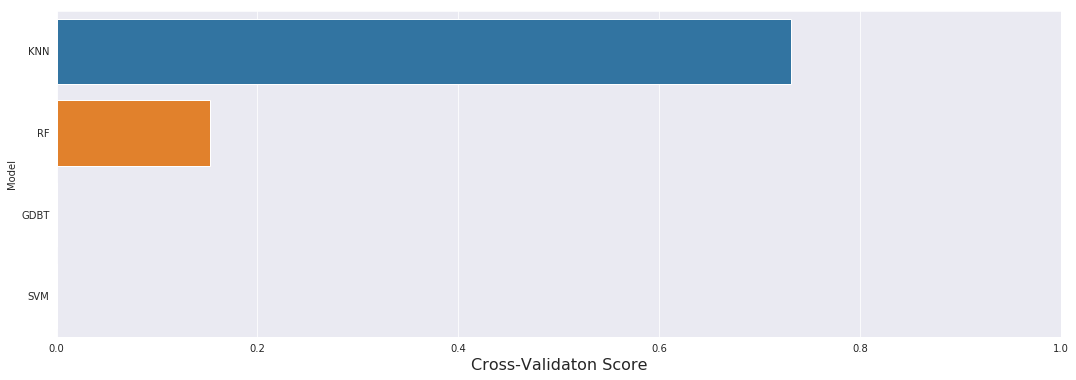

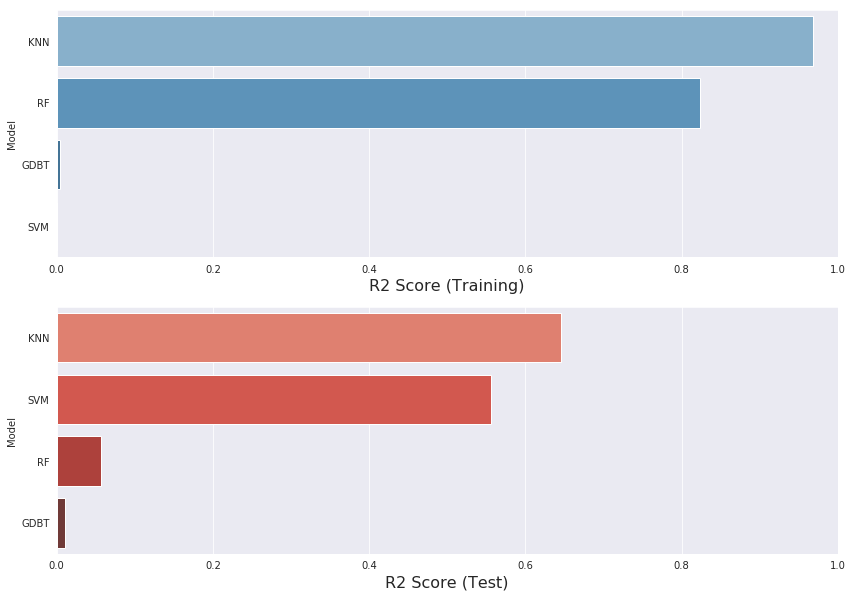

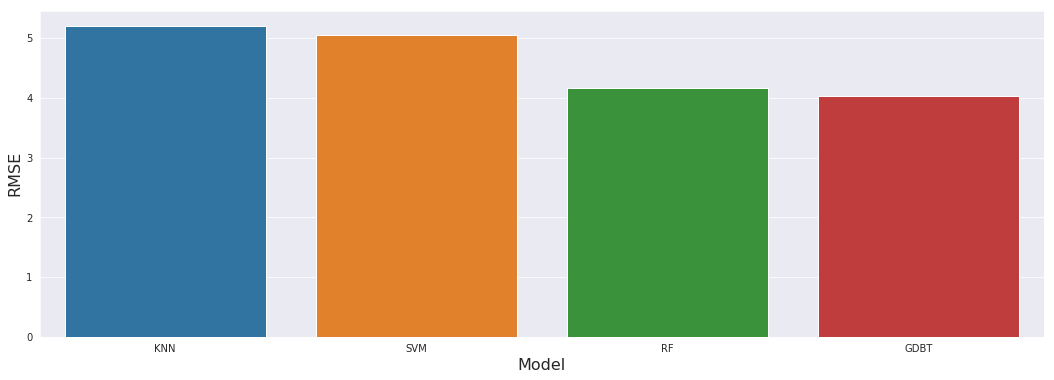

In [319]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['R2_Score(training)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 Score (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predict.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 Score (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

plt.show()


predict.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predict, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)

plt.show()

## <span id="3"></span> 2. 30min model 

In [320]:
X = dataset[['Notional','Premium']].iloc[:,:]

y = dataset.iloc[:,11]
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (2293, 2)
Shape of X_test:  (983, 2)
Shape of y_train:  (2293,)
Shape of y_test (983,)


In [321]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
from sklearn.metrics import r2_score
from sklearn import ensemble
# Predicting Cross Validation Score the Test set results
cv = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_train = regressor.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)

# Predicting R2 Score the Test set results
y_pred_test = regressor.predict(X_test)
r2_score_test = r2_score(y_test, y_pred_test)

# Predicting RMSE the Test set results
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("CV: ", cv.mean())
print('R2_score (train): ', r2_score_train)
print('R2_score (test): ', r2_score_test)
print("RMSE: ", rmse)

CV:  -0.0013905403249895643
R2_score (train):  0.004942774599283273
R2_score (test):  0.010384450473209128
RMSE:  4.037024001958802


In [322]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X_train)
y_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))
# Fitting the SVR Model to the dataset
from sklearn.svm import SVR
regressor_svr = SVR(kernel = 'rbf', gamma = 'scale')
regressor_svr.fit(X_scaled, y_scaled.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_svr = cross_val_score(estimator = regressor_svr, X = X_scaled, y = y_scaled.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_svr_train = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_train)))
r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

# Predicting R2 Score the Test set results
y_pred_svr_test = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_test)))
r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

# Predicting RMSE the Test set results
rmse_svr = (np.sqrt(mean_squared_error(y_test, y_pred_svr_test)))
print('CV: ', cv_svr.mean())
print('R2_score (train): ', r2_score_svr_train)
print('R2_score (test): ', r2_score_svr_test)
print("RMSE: ", rmse_svr)

CV:  -0.5056827274147545
R2_score (train):  -0.49408453055016177
R2_score (test):  -0.5566807967820515
RMSE:  5.063232381686357


In [323]:
#Step 4: Two K-nearest neighbor regression models with different configurations are used for training, and the test data are predicted respectively
from sklearn.neighbors import KNeighborsRegressor
#1.Initialize the k-nearest neighbor regressor and adjust the configuration so that the prediction mode is the mean regression：weights = 'uniform'
uni_knr = KNeighborsRegressor(weights='uniform')
uni_knr.fit(X_train,y_train)
uni_knr_y_predict = uni_knr.predict(X_test)
#2.The K-nearest neighbor regressor is initialized and the configuration is adjusted so that the prediction mode is weighted regression according to distance：weights = 'distance'
dis_knr = KNeighborsRegressor(weights='distance')
dis_knr.fit(X_train,y_train)
dis_knr_y_predict = dis_knr.predict(X_test)

#：The performance of K-nearest neighbor regression model under two configurations is evaluated under the same test set
#R-squared, MSE and MAE indicators were used for evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
#1.The prediction method is KNR of mean regression

In [324]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)
regressor_dt.fit(X_train, y_train)
# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = regressor_dt, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_dt_train = regressor_dt.predict(X_train)
r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

# Predicting R2 Score the Test set results
y_pred_dt_test = regressor_dt.predict(X_test)
r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

# Predicting RMSE the Test set results
rmse_dt = (np.sqrt(mean_squared_error(y_test, y_pred_dt_test)))
print('CV: ', cv_dt.mean())
print('R2_score (train): ', r2_score_dt_train)
print('R2_score (test): ', r2_score_dt_test)
print("RMSE: ", rmse_dt)

CV:  -0.7312663313387999
R2_score (train):  0.968278713830815
R2_score (test):  -0.6451986381697692
RMSE:  5.205197911552178


In [325]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_rf.fit(X_train, y_train.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = regressor_rf, X = X_scaled, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_rf_train = regressor_rf.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = regressor_rf.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print('CV: ', cv_rf.mean())
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("RMSE: ", rmse_rf)

CV:  -0.15238502149021363
R2_score (train):  0.8231085213245729
R2_score (test):  -0.056660643139363254
RMSE:  4.171534522988308


In [326]:
models = [('GDBT', rmse, r2_score_train, r2_score_test, cv.mean()),
          ('SVM', rmse_svr, r2_score_svr_train, abs(r2_score_svr_test), cv_svr.mean()),
          ('KNN', rmse_dt, r2_score_dt_train, abs(r2_score_dt_test),abs(cv_dt.mean())),
          ('RF', rmse_rf, r2_score_rf_train, abs(r2_score_rf_test),abs(cv_rf.mean())),]
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

Model      RMSE  R2_Score(training)  R2_Score(test)  Cross-Validation
0  GDBT  4.037024            0.004943        0.010384         -0.001391
1   SVM  5.063232           -0.494085        0.556681         -0.505683
2   KNN  5.205198            0.968279        0.645199          0.731266
3    RF  4.171535            0.823109        0.056661          0.152385

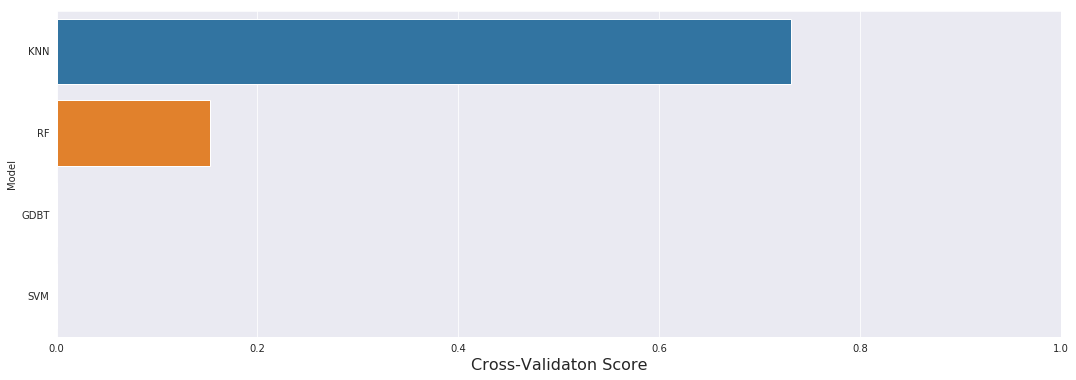

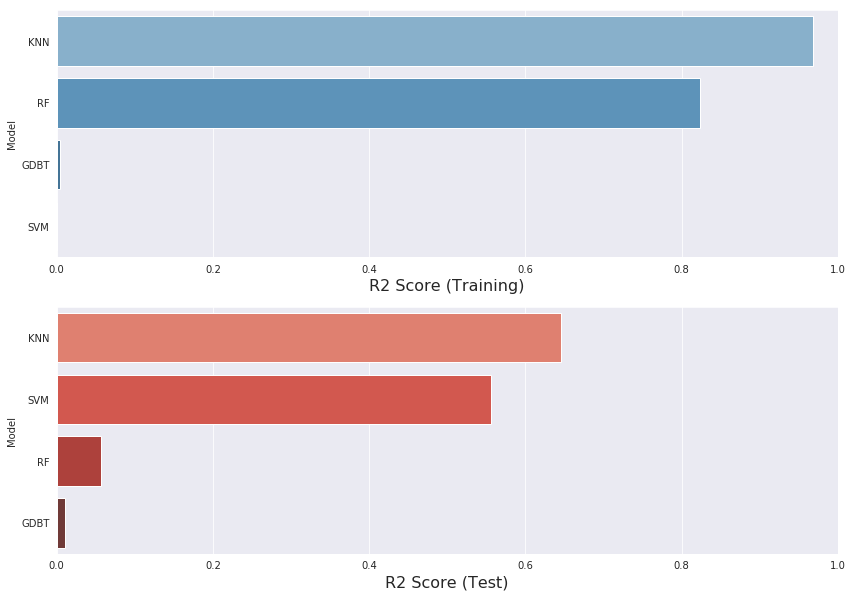

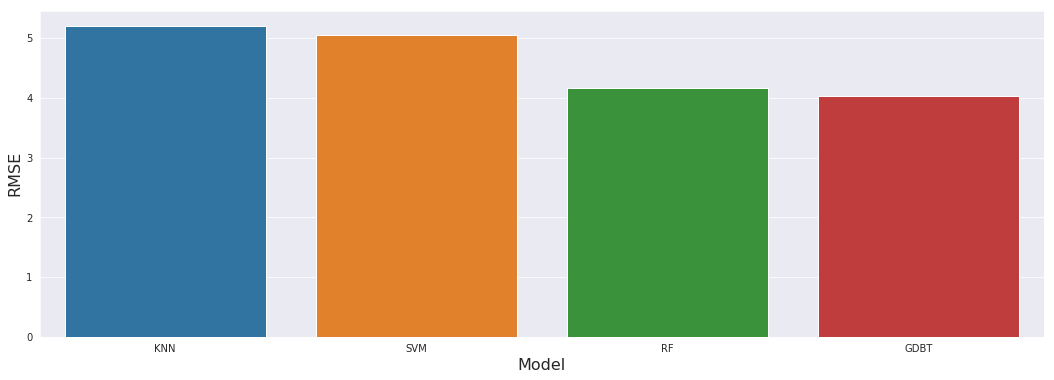

In [327]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['R2_Score(training)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 Score (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predict.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 Score (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

plt.show()


predict.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predict, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)

plt.show()

## <span id="3"></span> 3. 1hour model 

In [328]:
X = dataset[['Notional','Premium']].iloc[:,:]

y = dataset.iloc[:,10]
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (2293, 2)
Shape of X_test:  (983, 2)
Shape of y_train:  (2293,)
Shape of y_test (983,)


In [329]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
from sklearn.metrics import r2_score
from sklearn import ensemble
# Predicting Cross Validation Score the Test set results
cv = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_train = regressor.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)

# Predicting R2 Score the Test set results
y_pred_test = regressor.predict(X_test)
r2_score_test = r2_score(y_test, y_pred_test)

# Predicting RMSE the Test set results
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("CV: ", cv.mean())
print('R2_score (train): ', r2_score_train)
print('R2_score (test): ', r2_score_test)
print("RMSE: ", rmse)

CV:  -0.0013905403249895643
R2_score (train):  0.004942774599283273
R2_score (test):  0.010384450473209128
RMSE:  4.037024001958802


In [330]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X_train)
y_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))
# Fitting the SVR Model to the dataset
from sklearn.svm import SVR
regressor_svr = SVR(kernel = 'rbf', gamma = 'scale')
regressor_svr.fit(X_scaled, y_scaled.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_svr = cross_val_score(estimator = regressor_svr, X = X_scaled, y = y_scaled.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_svr_train = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_train)))
r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

# Predicting R2 Score the Test set results
y_pred_svr_test = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_test)))
r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

# Predicting RMSE the Test set results
rmse_svr = (np.sqrt(mean_squared_error(y_test, y_pred_svr_test)))
print('CV: ', cv_svr.mean())
print('R2_score (train): ', r2_score_svr_train)
print('R2_score (test): ', r2_score_svr_test)
print("RMSE: ", rmse_svr)

CV:  -0.5056827274147545
R2_score (train):  -0.49408453055016177
R2_score (test):  -0.5566807967820515
RMSE:  5.063232381686357


In [331]:
#Step 4: Two K-nearest neighbor regression models with different configurations are used for training, and the test data are predicted respectively
from sklearn.neighbors import KNeighborsRegressor
#1.Initialize the k-nearest neighbor regressor and adjust the configuration so that the prediction mode is the mean regression：weights = 'uniform'
uni_knr = KNeighborsRegressor(weights='uniform')
uni_knr.fit(X_train,y_train)
uni_knr_y_predict = uni_knr.predict(X_test)
#2.The K-nearest neighbor regressor is initialized and the configuration is adjusted so that the prediction mode is weighted regression according to distance：weights = 'distance'
dis_knr = KNeighborsRegressor(weights='distance')
dis_knr.fit(X_train,y_train)
dis_knr_y_predict = dis_knr.predict(X_test)

#：The performance of K-nearest neighbor regression model under two configurations is evaluated under the same test set
#R-squared, MSE and MAE indicators were used for evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
#1.The prediction method is KNR of mean regression

In [332]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)
regressor_dt.fit(X_train, y_train)
# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = regressor_dt, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_dt_train = regressor_dt.predict(X_train)
r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

# Predicting R2 Score the Test set results
y_pred_dt_test = regressor_dt.predict(X_test)
r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

# Predicting RMSE the Test set results
rmse_dt = (np.sqrt(mean_squared_error(y_test, y_pred_dt_test)))
print('CV: ', cv_dt.mean())
print('R2_score (train): ', r2_score_dt_train)
print('R2_score (test): ', r2_score_dt_test)
print("RMSE: ", rmse_dt)

CV:  -0.7312663313387999
R2_score (train):  0.968278713830815
R2_score (test):  -0.6451986381697692
RMSE:  5.205197911552178


In [333]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_rf.fit(X_train, y_train.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = regressor_rf, X = X_scaled, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_rf_train = regressor_rf.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = regressor_rf.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print('CV: ', cv_rf.mean())
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("RMSE: ", rmse_rf)

CV:  -0.15238502149021363
R2_score (train):  0.8231085213245729
R2_score (test):  -0.056660643139363254
RMSE:  4.171534522988308


In [334]:
models = [('GDBT', rmse, r2_score_train, r2_score_test, cv.mean()),
          ('SVM', rmse_svr, r2_score_svr_train, abs(r2_score_svr_test), cv_svr.mean()),
          ('KNN', rmse_dt, r2_score_dt_train, abs(r2_score_dt_test),abs(cv_dt.mean())),
          ('RF', rmse_rf, r2_score_rf_train, abs(r2_score_rf_test),abs(cv_rf.mean())),]
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

Model      RMSE  R2_Score(training)  R2_Score(test)  Cross-Validation
0  GDBT  4.037024            0.004943        0.010384         -0.001391
1   SVM  5.063232           -0.494085        0.556681         -0.505683
2   KNN  5.205198            0.968279        0.645199          0.731266
3    RF  4.171535            0.823109        0.056661          0.152385

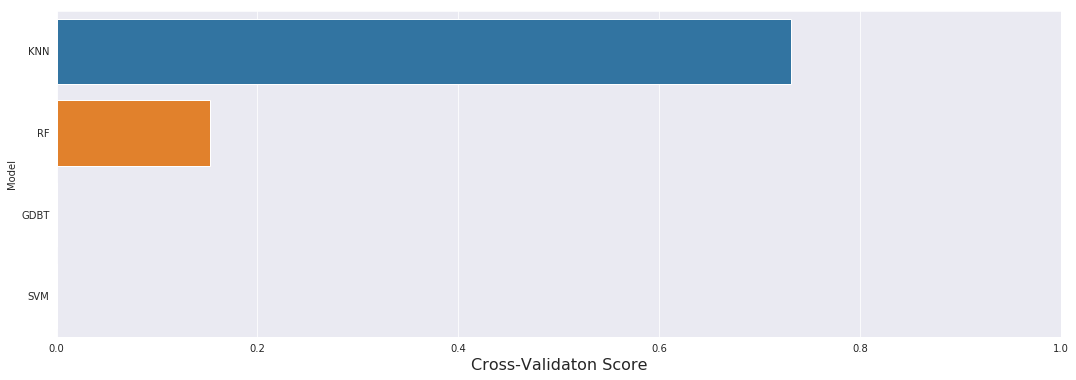

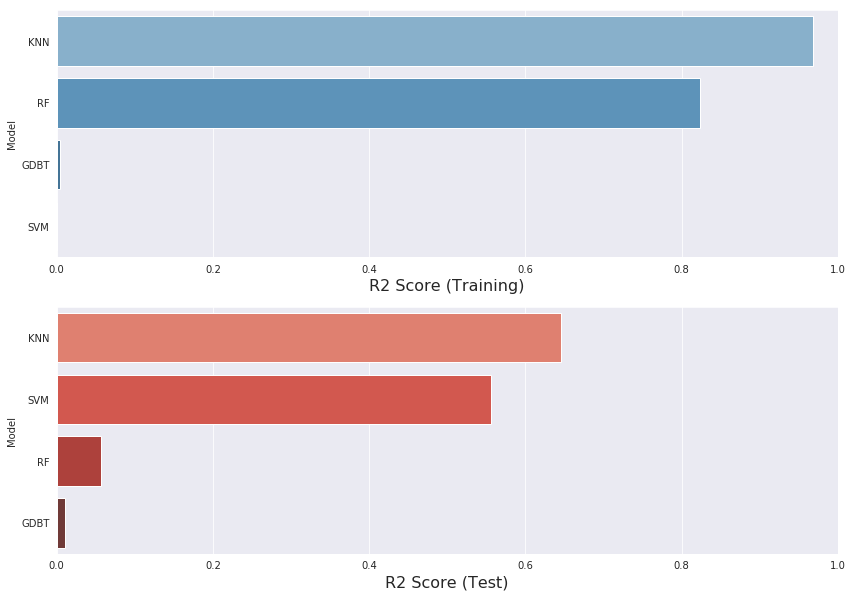

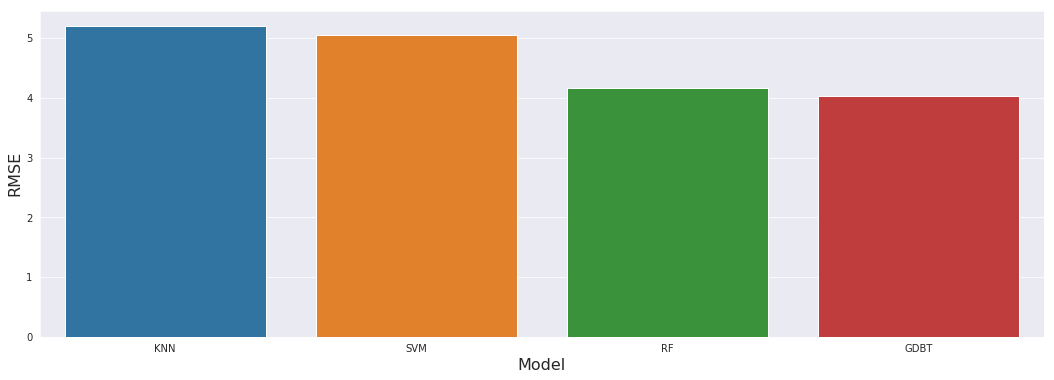

In [335]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['R2_Score(training)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 Score (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predict.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 Score (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

plt.show()


predict.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predict, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)

plt.show()

## <span id="3"></span> 1. 1day model 

In [336]:
X = dataset[['Notional','Premium']].iloc[:,:]

y = dataset.iloc[:,10]
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (2293, 2)
Shape of X_test:  (983, 2)
Shape of y_train:  (2293,)
Shape of y_test (983,)


In [337]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
from sklearn.metrics import r2_score
from sklearn import ensemble
# Predicting Cross Validation Score the Test set results
cv = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_train = regressor.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)

# Predicting R2 Score the Test set results
y_pred_test = regressor.predict(X_test)
r2_score_test = r2_score(y_test, y_pred_test)

# Predicting RMSE the Test set results
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("CV: ", cv.mean())
print('R2_score (train): ', r2_score_train)
print('R2_score (test): ', r2_score_test)
print("RMSE: ", rmse)

CV:  -0.0013905403249895643
R2_score (train):  0.004942774599283273
R2_score (test):  0.010384450473209128
RMSE:  4.037024001958802


In [338]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X_train)
y_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))
# Fitting the SVR Model to the dataset
from sklearn.svm import SVR
regressor_svr = SVR(kernel = 'rbf', gamma = 'scale')
regressor_svr.fit(X_scaled, y_scaled.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_svr = cross_val_score(estimator = regressor_svr, X = X_scaled, y = y_scaled.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_svr_train = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_train)))
r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

# Predicting R2 Score the Test set results
y_pred_svr_test = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_test)))
r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

# Predicting RMSE the Test set results
rmse_svr = (np.sqrt(mean_squared_error(y_test, y_pred_svr_test)))
print('CV: ', cv_svr.mean())
print('R2_score (train): ', r2_score_svr_train)
print('R2_score (test): ', r2_score_svr_test)
print("RMSE: ", rmse_svr)

CV:  -0.5056827274147545
R2_score (train):  -0.49408453055016177
R2_score (test):  -0.5566807967820515
RMSE:  5.063232381686357


In [339]:
#Step 4: Two K-nearest neighbor regression models with different configurations are used for training, and the test data are predicted respectively
from sklearn.neighbors import KNeighborsRegressor
#1.Initialize the k-nearest neighbor regressor and adjust the configuration so that the prediction mode is the mean regression：weights = 'uniform'
uni_knr = KNeighborsRegressor(weights='uniform')
uni_knr.fit(X_train,y_train)
uni_knr_y_predict = uni_knr.predict(X_test)
#2.The K-nearest neighbor regressor is initialized and the configuration is adjusted so that the prediction mode is weighted regression according to distance：weights = 'distance'
dis_knr = KNeighborsRegressor(weights='distance')
dis_knr.fit(X_train,y_train)
dis_knr_y_predict = dis_knr.predict(X_test)

#：The performance of K-nearest neighbor regression model under two configurations is evaluated under the same test set
#R-squared, MSE and MAE indicators were used for evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
#1.The prediction method is KNR of mean regression

In [340]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)
regressor_dt.fit(X_train, y_train)
# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = regressor_dt, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_dt_train = regressor_dt.predict(X_train)
r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

# Predicting R2 Score the Test set results
y_pred_dt_test = regressor_dt.predict(X_test)
r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

# Predicting RMSE the Test set results
rmse_dt = (np.sqrt(mean_squared_error(y_test, y_pred_dt_test)))
print('CV: ', cv_dt.mean())
print('R2_score (train): ', r2_score_dt_train)
print('R2_score (test): ', r2_score_dt_test)
print("RMSE: ", rmse_dt)

CV:  -0.7312663313387999
R2_score (train):  0.968278713830815
R2_score (test):  -0.6451986381697692
RMSE:  5.205197911552178


In [341]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_rf.fit(X_train, y_train.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = regressor_rf, X = X_scaled, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_rf_train = regressor_rf.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = regressor_rf.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print('CV: ', cv_rf.mean())
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("RMSE: ", rmse_rf)

CV:  -0.15238502149021363
R2_score (train):  0.8231085213245729
R2_score (test):  -0.056660643139363254
RMSE:  4.171534522988308


In [342]:
models = [('GDBT', rmse, r2_score_train, r2_score_test, cv.mean()),
          ('SVM', rmse_svr, r2_score_svr_train, abs(r2_score_svr_test), cv_svr.mean()),
          ('KNN', rmse_dt, r2_score_dt_train, abs(r2_score_dt_test),abs(cv_dt.mean())),
          ('RF', rmse_rf, r2_score_rf_train, abs(r2_score_rf_test),abs(cv_rf.mean())),]
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

Model      RMSE  R2_Score(training)  R2_Score(test)  Cross-Validation
0  GDBT  4.037024            0.004943        0.010384         -0.001391
1   SVM  5.063232           -0.494085        0.556681         -0.505683
2   KNN  5.205198            0.968279        0.645199          0.731266
3    RF  4.171535            0.823109        0.056661          0.152385

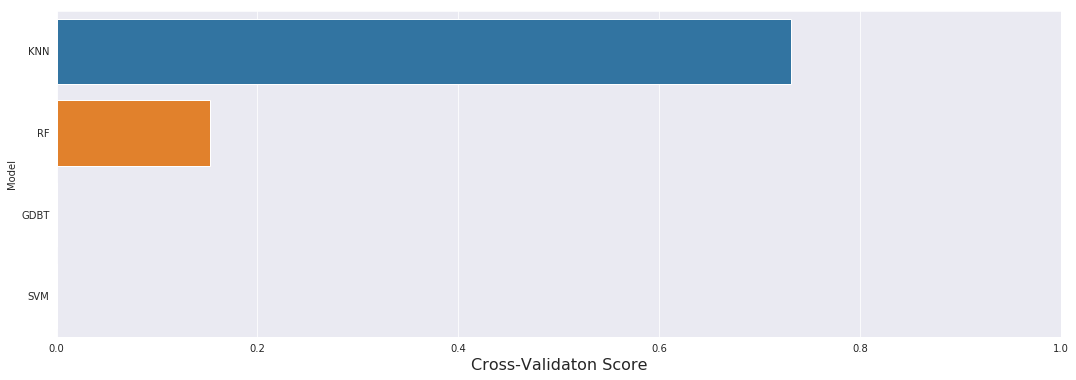

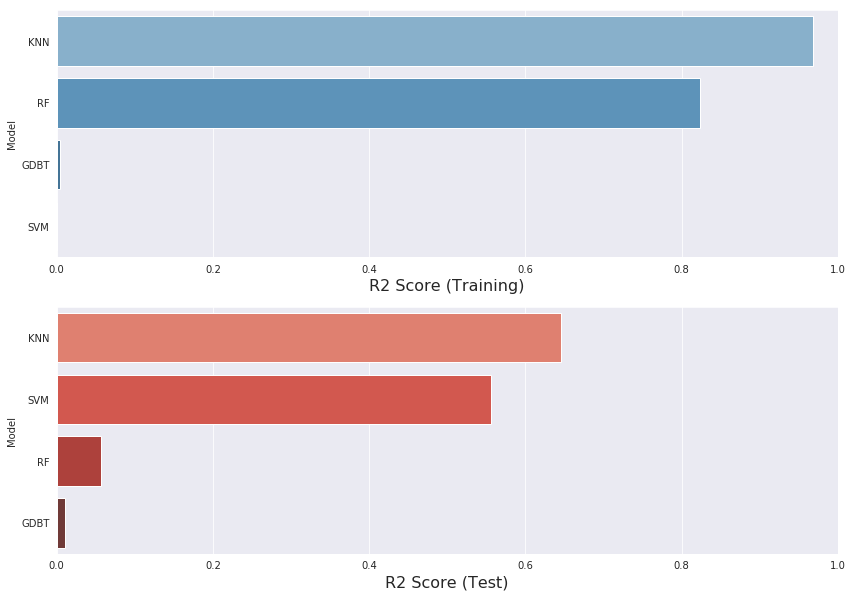

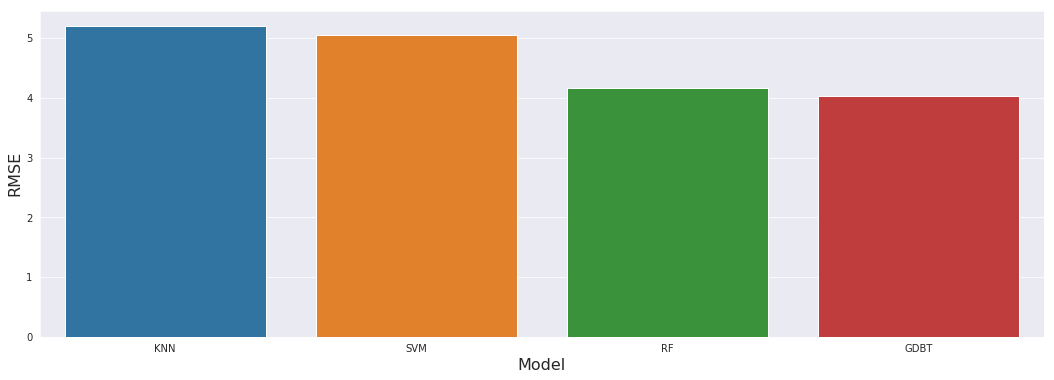

In [343]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['R2_Score(training)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 Score (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predict.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 Score (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

plt.show()


predict.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predict, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)

plt.show()

------------

**origin **

------------

In [ ]:
y = dataset.iloc[:,5]
X = dataset.drop('Premium', axis=1).iloc[:,:]

In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)

In [ ]:
dataset.head()

In [ ]:
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

### <span id="5"></span> ** Visualizing Data **

### <span id="5"></span> **Correlations can be found by thermal maps **

In [ ]:
corr = dataset.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(10, 10))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

In [ ]:
sns.pairplot(dataset)
plt.show()

## <span id="6"></span> ** 4. Regression Models **

### <span id="7"></span> ** gdbt **

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import r2_score
from sklearn import ensemble
# Predicting Cross Validation Score the Test set results
cv = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_train = regressor.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)

# Predicting R2 Score the Test set results
y_pred_test = regressor.predict(X_test)
r2_score_test = r2_score(y_test, y_pred_test)

# Predicting RMSE the Test set results
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("CV: ", cv.mean())
print('R2_score (train): ', r2_score_train)
print('R2_score (test): ', r2_score_test)
print("RMSE: ", rmse)

### <span id="11"></span> ** SVM **

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X_train)
y_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))

In [ ]:
# Fitting the SVR Model to the dataset
from sklearn.svm import SVR
regressor_svr = SVR(kernel = 'rbf', gamma = 'scale')
regressor_svr.fit(X_scaled, y_scaled.ravel())

In [ ]:
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_svr = cross_val_score(estimator = regressor_svr, X = X_scaled, y = y_scaled.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_svr_train = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_train)))
r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

# Predicting R2 Score the Test set results
y_pred_svr_test = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_test)))
r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

# Predicting RMSE the Test set results
rmse_svr = (np.sqrt(mean_squared_error(y_test, y_pred_svr_test)))
print('CV: ', cv_svr.mean())
print('R2_score (train): ', r2_score_svr_train)
print('R2_score (test): ', r2_score_svr_test)
print("RMSE: ", rmse_svr)

In [ ]:
#Step 4: Two K-nearest neighbor regression models with different configurations are used for training, and the test data are predicted respectively
from sklearn.neighbors import KNeighborsRegressor
#1.Initialize the k-nearest neighbor regressor and adjust the configuration so that the prediction mode is the mean regression：weights = 'uniform'
uni_knr = KNeighborsRegressor(weights='uniform')
uni_knr.fit(X_train,y_train)
uni_knr_y_predict = uni_knr.predict(X_test)
#2.The K-nearest neighbor regressor is initialized and the configuration is adjusted so that the prediction mode is weighted regression according to distance：weights = 'distance'
dis_knr = KNeighborsRegressor(weights='distance')
dis_knr.fit(X_train,y_train)
dis_knr_y_predict = dis_knr.predict(X_test)

#第五步：The performance of K-nearest neighbor regression model under two configurations is evaluated under the same test set
#R-squared, MSE and MAE indicators were used for evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
#1.The prediction method is KNR of mean regression
print 'R-squared value of uniform-weighted KNR is',uni_knr.score(X_test,y_test)
print 'the MSE of uniform-weighted KNR is',mean_squared_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(uni_knr_y_predict))
print 'the MAE of uniform-weighted KNR is',mean_absolute_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(uni_knr_y_predict))
#2.The prediction method is KNR according to the weighted distance
print 'R-squared value of distance-weighted KNR is',dis_knr.score(X_test,y_test)
print 'the MSE of distance-weighted KNR is',mean_squared_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(dis_knr_y_predict))
print 'the MAE of distance-weighted KNR is',mean_absolute_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(dis_knr_y_predict))

In [ ]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)
regressor_dt.fit(X_train, y_train)
# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = regressor_dt, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_dt_train = regressor_dt.predict(X_train)
r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

# Predicting R2 Score the Test set results
y_pred_dt_test = regressor_dt.predict(X_test)
r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

# Predicting RMSE the Test set results
rmse_dt = (np.sqrt(mean_squared_error(y_test, y_pred_dt_test)))
print('CV: ', cv_dt.mean())
print('R2_score (train): ', r2_score_dt_train)
print('R2_score (test): ', r2_score_dt_test)
print("RMSE: ", rmse_dt)

### <span id="13"></span> ** Random Forest Regression **

In [ ]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_rf.fit(X_train, y_train.ravel())

In [ ]:
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = regressor_rf, X = X_scaled, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_rf_train = regressor_rf.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = regressor_rf.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print('CV: ', cv_rf.mean())
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("RMSE: ", rmse_rf)

## <span id="14"></span> ** 5. Measuring the Error **

In [ ]:
models = [('GDBT', rmse, r2_score_train, r2_score_test, cv.mean()),
          ('SVM', rmse_svr, r2_score_svr_train, abs(r2_score_svr_test), cv_svr.mean()),
          ('KNN', rmse_dt, r2_score_dt_train, abs(r2_score_dt_test),abs(cv_dt.mean())),
          ('RF', rmse_rf, r2_score_rf_train, abs(r2_score_rf_test),abs(cv_rf.mean())),]

In [ ]:
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

### <span id="15"></span> ** Visualizing Model Performance **

In [ ]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

In [ ]:
f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['R2_Score(training)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 Score (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predict.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 Score (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

plt.show()

In [ ]:
predict.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predict, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)

plt.show()

## <span id="16"></span> ** 6. Conclusion **